In [1]:
from __future__ import print_function, division

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from skimage.measure import compare_ssim as ssim
import time
import os
import copy
import h5py
import sys
import math
import random
import torch
import scipy
import numpy.polynomial.polynomial as poly
from PIL import Image
import gc
import cv2

%matplotlib inline

sys.path.append('../../../code')

from python.finetune_commons import show_images, ft_train_model, visualize_model
from python.commons import load_dict_from_hdf5, save_dict_to_hdf5, inc_inference_e2e, full_inference_e2e, adaptive_drilldown, generate_heatmap
from python.vgg16 import VGG16
from python.resnet18 import ResNet18
from python.inception3 import Inception3

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def inc_inference_selected(model, file_path, patch_size, stride, patch_positions, batch_size=64, beta=1.0,
                           x0=0, y0=0, image_size=224, x_size=224, y_size=224, gpu=True, version='v1',
                           n_labels=1000, weights_data=None, loader=None, c=0.0):

    if loader == None:
        loader = transforms.Compose([transforms.Resize([image_size, image_size]), transforms.ToTensor()])
    orig_image = Image.open(file_path).convert('RGB')
    orig_image = loader(orig_image).unsqueeze(0)

    if gpu:
        orig_image = orig_image.cuda()

    image_patches = torch.FloatTensor(3, patch_size, patch_size).fill_(c).repeat(batch_size, 1, 1, 1)
        
    x_output_width = int(math.ceil((x_size*1.0 - patch_size) / stride))
    y_output_width = int(math.ceil((y_size*1.0 - patch_size) / stride))

    total_number = x_output_width * y_output_width
    logit_values = np.zeros((x_output_width, y_output_width), dtype=np.float32)
    
    num_batches = int(math.ceil(len(patch_positions) * 1.0 / batch_size))
    inc_model = model(beta=beta, gpu=gpu, n_labels=n_labels, weights_data=weights_data).eval()
    
    if gpu:
        inc_model = inc_model.cuda()
        
    temp = inc_model.forward_materialized(orig_image).cpu().data.numpy()
    logit_index = np.argmax(temp)
    prob = np.max(temp)
 
    locations = torch.zeros([batch_size, 2], dtype=torch.int32)
    
    for i in range(num_batches):
        for j in range(batch_size):
            index = j * num_batches + i
            if index >= len(patch_positions):
                break

            x, y = patch_positions[index]
            x = x*stride + x0
            y = y*stride + y0
            x,y = int(x), int(y)
            
            locations[j, 0] = x
            locations[j, 1] = y

        if version == 'v1':
            logits = inc_model.forward_gpu(image_patches, locations, p_height=patch_size, p_width=patch_size)
        else:
            logits = inc_model.forward_pytorch(image_patches, locations, p_height=patch_size, p_width=patch_size)
            
        logits = logits.cpu().data.numpy()[:, logit_index].flatten().tolist()

        for logit, j in zip(logits, range(batch_size)):
            index = j * num_batches + i
            if index >= len(patch_positions):
                break
            x, y = patch_positions[index]
            logit_values[x, y] = logit

    del inc_model
    gc.collect()

    return logit_values, prob, logit_index



def adaptive_drilldown(model, file_path, patch_size, stride, batch_size=128, image_size=224,
                       x_size=224, y_size=224, beta=1.0, percentile=25, S1=8, gpu=True, version='v1',
                       n_labels=1000, weights_data=None, loader=None, c=0.0):
    final_out_width = int(math.ceil((image_size*1.0-patch_size)/stride))


    s1 = S1
    
    #checking for interested regions
    temp1, prob, logit_index = inc_inference_e2e(model, file_path, patch_size, s1,
                                    batch_size=batch_size, beta=beta, image_size=image_size, x_size=x_size,
                              y_size=y_size, gpu=gpu, version=version, weights_data=weights_data, loader=loader, c=c)

    temp1 = cv2.resize(temp1, (final_out_width, final_out_width), interpolation=cv2.INTER_LINEAR)
    threshold = np.percentile(temp1, percentile)
    temp1 = np.where(temp1 <= threshold, 0, temp1)
    idx = np.argwhere(temp1 <= threshold)
    
    #drilldown into interested regions
    temp2, prob, logit_index = inc_inference_selected(model, file_path, patch_size, stride, idx.tolist(),
                                    batch_size=batch_size, beta=beta, image_size=image_size,
                              x_size=image_size, y_size=image_size, gpu=gpu, version=version,
                            weights_data=weights_data, loader=loader, c=c)

    
    
    return np.add(temp1, temp2), prob, logit_index
    #return temp1, prob, logit_index


def ada_drill(image_file_path, model, beta, patch_size=4, stride=1, r_drill_down=25, S1=8, weights_data=None):
    torch.cuda.synchronize()
    
    with torch.no_grad():
        x, prob, logit_index = adaptive_drilldown(model, image_file_path, patch_size, stride,
                                batch_size=128, beta=beta, gpu=gpu, version='v1', percentile=r_drill_down,
                                S1=S1, image_size=image_size, x_size=image_size, y_size=image_size,
                              weights_data=weights_data)
    torch.cuda.synchronize()
    return x, prob, logit_index

In [3]:
random.seed(127)

dataset = "oct"

gpu = True
batch_size = 256
patch_size = 16
stride = 4
file_amount = 30

def inc_inference(model, image_file_path, beta, patch_size=4, stride=1, weights_data=None, image_size = 224):
    torch.cuda.synchronize()
    with torch.no_grad():
        x, prob, logit_index = inc_inference_e2e(model, image_file_path, patch_size, stride,
                              batch_size=batch_size, beta=beta, gpu=gpu, version='v1',
                              weights_data=weights_data, c=0.0,
                             image_size=image_size, x_size=image_size, y_size=image_size)

    torch.cuda.synchronize()

    return x, prob, logit_index


image_files = []
# OCT
if dataset == 'oct':
    temp = os.listdir('../../../data/oct/test/DRUSEN')
    for name in temp:
        if name.endswith('jpeg'):
            image_files.append('../../../data/oct/test/DRUSEN/'+name)

    temp = os.listdir('../../../data/oct/test/DME')
    for name in temp:
        if name.endswith('jpeg'):
            image_files.append('../../../data/oct/test/DME/'+name)

    temp = os.listdir('../../../data/oct/test/CNV')
    for name in temp:
        if name.endswith('jpeg'):
            image_files.append('../../../data/oct/test/CNV/'+name)


    temp = os.listdir('../../../data/oct/test/NORMAL')        
    for name in temp:
        if name.endswith('jpeg'):
            image_files.append('../../../data/oct/test/NORMAL/'+name)

elif dataset == 'chest_xray':
    temp = os.listdir('../../../data/chest_xray/test/BACTERIAL')
    for name in temp:
        if name.endswith('jpeg'):
            image_files.append('../../../data/chest_xray/test/BACTERIAL/'+name)

    temp = os.listdir('../../../data/chest_xray/test/VIRAL')
    for name in temp:
        if name.endswith('jpeg'):
            image_files.append('../../../data/chest_xray/test/VIRAL/'+name)

    temp = os.listdir('../../../data/chest_xray/test/NORMAL')
    for name in temp:
        if name.endswith('jpeg'):
            image_files.append('../../../data/chest_xray/test/NORMAL/'+name)


elif dataset == 'imagenet':
# ImageNet
    temp = os.listdir('../../../data/imagenet-sample')
    for name in temp:
        if name.endswith('jpg'):
            image_files.append('../../../data/imagenet-sample/'+name)

image_files = random.sample(image_files, file_amount)
random.shuffle(image_files)


drill_down_values = [10, 20, 30, 40, 50]
S1s = [8, 10, 12, 14, 16]

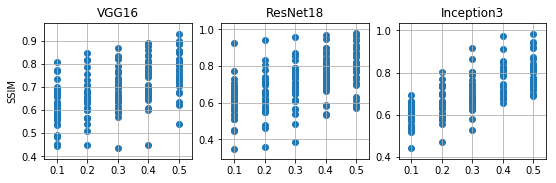

In [5]:
plt.figure(figsize=(9,2.5))

i = 1

for model,model_name,weight_file in zip([VGG16, ResNet18, Inception3], ['VGG16', 'ResNet18', 'Inception3'],
        ['../../../code/python/vgg16_weights_ptch.h5', '../../../code/python/resnet18_weights_ptch.h5',
            '../../../code/python/inception3_weights_ptch.h5']):

    weights_data = load_dict_from_hdf5(weight_file, gpu=gpu)

    if dataset in ['oct', 'chest_xray']:
        temp_weights_data = load_dict_from_hdf5('../../../exps/'+dataset+'_'+model_name.lower()+'_ptch.h5', gpu=gpu)

    if model_name == 'VGG16':
        #continue
        image_size = 224
        if dataset in ['oct', 'chest_xray']:
            weights_data['fc8_W:0'] = temp_weights_data['fc8_W:0']
            weights_data['fc8_b:0'] = temp_weights_data['fc8_b:0']
    elif model_name == 'ResNet18':
        image_size = 224
        if dataset in ['oct', 'chest_xray']:
            weights_data['fc:w'] = temp_weights_data['fc:w']
            weights_data['fc:b'] = temp_weights_data['fc:b']
    elif model_name == 'Inception3':
        #continue
        image_size = 299
        if dataset in ['oct', 'chest_xray']:
            weights_data['482.fc.weight'] = temp_weights_data['482.fc.weight']
            weights_data['483.fc.bias'] = temp_weights_data['483.fc.bias']
            
    y_ssim = []
    x_vals = []

    for file_path in image_files:
        x, prob, logit_index = inc_inference(model, file_path, 1.0, patch_size=patch_size, stride=stride,
                                 weights_data=weights_data, image_size=image_size)

        orig_hm = generate_heatmap(file_path, x, show=False, label="", prob=prob, width=image_size)
        
        for r_d in drill_down_values:
                x, prob, logit_index = ada_drill(file_path, model, 1.0, patch_size=patch_size, stride=stride,
                                                 r_drill_down=r_d, S1=12, weights_data=weights_data)
                hm = generate_heatmap(file_path, x, show=False, label="", prob=prob, width=image_size)

                if hm.shape[0] < 7:
                    win_size=3
                else:
                    win_size=None

                ssim_value = ssim(orig_hm, hm, data_range=255, multichannel=True, win_size=win_size)
                y_ssim.append(ssim_value)
                x_vals.append(r_d/100.0)

            
    ax = plt.subplot(1,3,i)
    plt.scatter(x_vals, y_ssim)
    
    ax.set_title(model_name)
    
    plt.grid()
    plt.xticks([x/100.0 for x in drill_down_values], [x/100.0 for x in drill_down_values])

    if i == 1:
        plt.ylabel('SSIM')
    
    i += 1
    
plt.savefig('../images/ada_ssim_drill_down_'+dataset+'_test.pdf', bbox_inches='tight')    

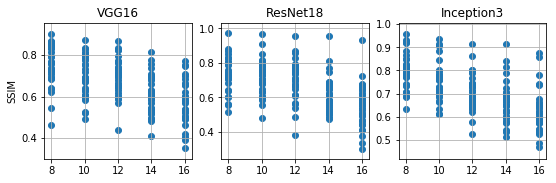

In [5]:
plt.figure(figsize=(9,2.5))

i = 1

for model,model_name,weight_file in zip([VGG16, ResNet18, Inception3], ['VGG16', 'ResNet18', 'Inception3'],
        ['../../../code/python/vgg16_weights_ptch.h5', '../../../code/python/resnet18_weights_ptch.h5',
            '../../../code/python/inception3_weights_ptch.h5']):

    weights_data = load_dict_from_hdf5(weight_file, gpu=gpu)

    if dataset in ['oct', 'chest_xray']:
        temp_weights_data = load_dict_from_hdf5('../../../exps/'+dataset+'_'+model_name.lower()+'_ptch.h5', gpu=gpu)

    if model_name == 'VGG16':
        #continue
        image_size = 224
        if dataset in ['oct', 'chest_xray']:
            weights_data['fc8_W:0'] = temp_weights_data['fc8_W:0']
            weights_data['fc8_b:0'] = temp_weights_data['fc8_b:0']
    elif model_name == 'ResNet18':
        image_size = 224
        if dataset in ['oct', 'chest_xray']:
            weights_data['fc:w'] = temp_weights_data['fc:w']
            weights_data['fc:b'] = temp_weights_data['fc:b']
    elif model_name == 'Inception3':
        #continue
        image_size = 299
        if dataset in ['oct', 'chest_xray']:
            weights_data['482.fc.weight'] = temp_weights_data['482.fc.weight']
            weights_data['483.fc.bias'] = temp_weights_data['483.fc.bias']
            
    y_ssim = []
    x_vals = []

    for file_path in image_files:
        x, prob, logit_index = inc_inference(model, file_path, 1.0, patch_size=patch_size, stride=stride,
                                 weights_data=weights_data, image_size=image_size)

        orig_hm = generate_heatmap(file_path, x, show=False, label="", prob=prob, width=image_size)


        for s1 in S1s:
            x, prob, logit_index = ada_drill(file_path, model, 1.0, patch_size=patch_size, stride=stride,
                                                 r_drill_down=30, S1=s1, weights_data=weights_data)
            hm = generate_heatmap(file_path, x, show=False, label="", prob=prob, width=image_size)

            if hm.shape[0] < 7:
                win_size=3
            else:
                win_size=None

            ssim_value = ssim(orig_hm, hm, data_range=255, multichannel=True, win_size=win_size)
            y_ssim.append(ssim_value)
            x_vals.append(s1)

            
    ax = plt.subplot(1,3,i)
    plt.scatter(x_vals, y_ssim)
    
    ax.set_title(model_name)
    
    plt.grid()
    plt.xticks(S1s, S1s)

    if i == 1:
        plt.ylabel('SSIM')
    
    i += 1
    
plt.savefig('../images/ada_ssim_speedup_'+dataset+'_test.pdf', bbox_inches='tight')    